# Out-of-Distribution Detection for Model Refinement in Cardiac Image Segmentation

In [ ]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-d072934d-23c0-1519-bbad-ab5f66387862)


In [ ]:
import random
import numpy as np
import torch

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Install requirements

#### megatools

In [ ]:
!sudo apt-get install megatools

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  megatools
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 148 kB of archives.
After this operation, 1,097 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 megatools amd64 1.9.98-1build2 [148 kB]
Fetched 148 kB in 0s (2,043 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package megatools.
(Reading database ... 155047 files and direct

#### batchgenerators

In [ ]:
!pip install --upgrade batchgenerators

     |████████████████████████████████| 57 kB 5.6 MB/s 
     |████████████████████████████████| 96 kB 6.7 MB/s 
  Created wheel for batchgenerators: filename=batchgenerators-0.23-py3-none-any.whl size=84780 sha256=706c356c2f541d374c9f6afa911fcff850004ed7af0667e5f2a016f4c22b5392
  Stored in directory: /root/.cache/pip/wheels/81/3d/a2/9a602ce56458c684d2962ec89eddd6bc06b00687735e2dd11a
Successfully built batchgenerators


#### medpy

In [ ]:
!pip install medpy

     |████████████████████████████████| 151 kB 13.5 MB/s 
     |████████████████████████████████| 48.4 MB 8.6 kB/s 
  Created wheel for medpy: filename=MedPy-0.4.0-cp37-cp37m-linux_x86_64.whl size=754471 sha256=4cf8c44eebe12c8f4c0e1c8bf0bcfbff1c24796f76625eb2ca70c1f951bd4cf6
  Stored in directory: /root/.cache/pip/wheels/b0/57/3a/da1183f22a6afb42e11138daa6a759de233fd977a984333602
Successfully built medpy


#### nibabel

In [ ]:
!pip install nibabel

## Import data

In [ ]:
!git clone https://github.com/manigalati/MnMs2

Cloning into 'MnMs2'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 40 (delta 19), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (40/40), done.


In [ ]:
%cd /content/MnMs2

/content/MnMs2


In [ ]:
!megadl "https://mega.nz/#!RERgEZhK!C9SXLaRV6Ep3pRn5ips_rGLsHUxP9wDZeJlBOSY6Af4"


ERROR: Download failed for 'https://mega.nz/#!RERgEZhK!C9SXLaRV6Ep3pRn5ips_rGLsHUxP9wDZeJlBOSY6Af4': Data download failed: Server returned 509


In [ ]:
!mkdir data
#MnMs2 dataset
!python gdrivedl.py https://drive.google.com/open?id=1-18mR3kwzErkqeTDZ-_UzQtalvnYK1fD data/
#vendor information
!python gdrivedl.py https://drive.google.com/open?id=1B8Rv0xGExxEahnYE7LMx0MeiJVXdaDPM data/

data/MnM-2.rar
[==================================================] 5618.07MB/5618.07MB
data/MNM2_vendor_information_training_set.csv
[==================================================] 0.00MB/0.00MB


In [ ]:
!unrar e data/MnM-2.rar data/
!rm data/MnM-2.rar


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from data/MnM-2.rar

Extracting  data/001_LA_CINE.nii.gz                                        0%  OK 
Extracting  data/001_LA_ED.nii.gz                                          0%  OK 
Extracting  data/001_LA_ED_gt.nii.gz                                       0%  OK 
Extracting  data/001_LA_ES.nii.gz                                          0%  OK 
Extracting  data/001_LA_ES_gt.nii.gz                                       0%  OK 
Extracting  data/001_SA_CINE.nii.gz                                        0%  OK 
Extracting  data/001_SA_ED.nii.gz                                          0%  OK 
Extracting  data/001_SA_ED_gt.nii.gz                                       0%  OK 
Extracting  data/001_SA_ES.nii.gz                                          0%  OK 
Extracting  data/001_SA_ES_gt.nii.gz                                   

## Data preparation

In [ ]:
import os
from utils import get_vendor_info
from utils import get_splits
from utils import generate_patient_info, crop_image
from utils import preprocess, preprocess_image, inSplit

The challenge cohort was composed of 360 patients with different rigth ventricle and left ventricle pathologies as well as healthy subjects. All subjects were scanned in four clinical centres in two different countries (Spain, Germany) using four different magnetic resonance scanner vendors (Siemens, General Electric and Philips ).

The training set contained 200 annotated images from four different centres. The CMR images have been segmented by experienced clinicians from the respective institutions, including contours for the left (LV) and right ventricle (RV) blood pools, as well as for the left ventricular myocardium (MYO). Labels are: 1 (LV), 2 (MYO) and 3 (RV) in both short-axis and long-axis views with a variety of difficult RV pathologies and remodelling as well as LV pathologies. This year we will focus on RV segmentation. Labels 1 and 2 will be provided but will not score in the final challenge results. 40 cases, 5 for each pathology, will be used to create a public leaderboard and will be added to the final testing set. Two pathologies (Tricuspidal Regurgitation and Congenital Arrhythmogenesis) will be not present in the training set but in the validation and testing sets to evaluate generalisation to unseen pathologies.

<table style="width:70%; margin: auto">
        <tbody><tr>
            <th>Pathology</th><th>Num. studies training</th> <th>Num. studies validation</th>
        </tr>
        <tr>
            <td style="text-align:left">Normal subjects</td><td>40</td><td>5</td>
        </tr>
        <tr>
            <td style="text-align:left">Dilated Left Ventricle</td><td>30</td><td>5</td>
        </tr>
        <tr>
            <td style="text-align:left">Hypertrophic Cardiomyopathy</td><td>30</td><td>5</td>
        </tr>
        <tr>
            <td style="text-align:left">Congenital Arrhythmogenesis</td><td>20</td><td>5</td>
        </tr>
        <tr>
            <td style="text-align:left">Tetralogy of Fallot</td><td>20</td><td>5</td>
        </tr>
        <tr>      
            <td style="text-align:left">Interatrial Comunication</td><td>20</td><td>5</td>
        </tr>
        <tr>       
            <td style="text-align:left">Dilated Right Ventricle</td><td>0</td><td>5</td>
        </tr>
        <tr>
            <td style="text-align:left">Tricuspidal Regurgitation</td><td>0</td><td>5</td>
        </tr>
</tbody></table>


In [ ]:
vendor_info = get_vendor_info("data/MNM2_vendor_information_training_set.csv")
vendor_info

,SUBJECT_CODE,VENDOR,PATH
0,001_SA,GE MEDICAL SYSTEMS,data/001_SA_{}.nii.gz
1,001_LA,GE MEDICAL SYSTEMS,data/001_LA_{}.nii.gz
2,002_SA,GE MEDICAL SYSTEMS,data/002_SA_{}.nii.gz
3,002_LA,GE MEDICAL SYSTEMS,data/002_LA_{}.nii.gz
4,003_SA,GE MEDICAL SYSTEMS,data/003_SA_{}.nii.gz
...,...,...,...
395,198_LA,NaN,data/198_LA_{}.nii.gz
396,199_SA,NaN,data/199_SA_{}.nii.gz
397,199_LA,NaN,data/199_LA_{}.nii.gz
398,200_SA,NaN,data/200_SA_{}.nii.gz


In [ ]:
vendor_info[['VENDOR','SUBJECT_CODE']].groupby(['VENDOR']).count().rename(columns={'SUBJECT_CODE':'NUM_STUDIES'})

,NUM_STUDIES
VENDOR,
GE MEDICAL SYSTEMS,52
Philips Medical Systems,128
SIEMENS,140


In [ ]:
if not os.path.isdir("preprocessed"):
    os.makedirs("preprocessed")
splits = get_splits(os.path.join("preprocessed", "splits.pkl"))

In [ ]:
patient_info = generate_patient_info(vendor_info, os.path.join("preprocessed", "patient_info.pkl"))

In [ ]:
spacings = [
    patient_info["{:03d}_{}".format(id, axis)]["spacing"] for axis in ["SA", "LA"] for id in (
        splits["train"]["lab"] + splits["train"]["ulab"] + splits["val"]
    )
]
spacing_target = np.percentile(np.vstack(spacings), 50, 0)

if not os.path.isdir("preprocessed/training/labelled"): os.makedirs("preprocessed/training/labelled")
if not os.path.isdir("preprocessed/training/unlabelled"): os.makedirs("preprocessed/training/unlabelled")
if not os.path.isdir("preprocessed/validation/"): os.makedirs("preprocessed/validation/")
if not os.path.isdir("preprocessed/soft_validation/"): os.makedirs("preprocessed/soft_validation/")
if not os.path.isdir("preprocessed/testing/"): os.makedirs("preprocessed/testing/")

preprocess(
    {k:v for k,v in patient_info.items() if inSplit(k, splits["train"]["lab"])},
    spacing_target, "preprocessed/training/labelled/"
)
preprocess(
    {k:v for k,v in patient_info.items() if inSplit(k, splits["train"]["ulab"])},
    spacing_target, "preprocessed/training/unlabelled/"
)
preprocess(
    {k:v for k,v in patient_info.items() if inSplit(k, splits["val"])},
    spacing_target, "preprocessed/validation/"
)
preprocess(
    {k:v for k,v in patient_info.items() if inSplit(k, splits["val"])},
    spacing_target, "preprocessed/soft_validation/", soft_preprocessing=True
)
preprocess(
    {k:v for k,v in patient_info.items() if inSplit(k, splits["test"])},
    spacing_target, "preprocessed/testing/", soft_preprocessing=True
)

## $\mathcal{M}$ - Supervised Training

In [ ]:
import torch.nn as nn
import os
import torch

from baseline_1 import Baseline_1
from baseline_2 import Baseline_2
from utils import AttrDict
from utils import GDLoss, CELoss
from utils import device
from utils import Validator, Checkpointer
from utils import supervised_training
from utils import ACDCDataLoader, ACDCAllPatients
from utils import BATCH_SIZE, EPOCHS, CKPT
from utils import transform_augmentation_downsample, transform
from utils import plot_history

In [ ]:
Model = Baseline_2

model = nn.ModuleDict([
    [axis, Model(
        AttrDict(**{
            "lr": 0.01,
            "functions": [GDLoss, CELoss]
        })
    )] for axis in ["SA", "LA"]
]).to(device)

ckpts = None
if ckpts is not None:
    for axis, ckpt in ckpts.items():
        _, start = os.path.split(ckpt)
        start = int(start.replace(".pth", ""))
        ckpt = torch.load(ckpt)
        model[axis].load_state_dict(ckpt["M"])
        model[axis].optimizer.load_state_dict(ckpt["M_optim"])
else:
    start = 1
print(model)

ModuleDict(
  (SA): Baseline_2(
    (unet): Generic_UNet(
      (conv_blocks_localization): ModuleList(
        (0): Sequential(
          (0): StackedConvLayers(
            (blocks): Sequential(
              (0): ConvDropoutNormNonlin(
                (conv): Conv2d(960, 480, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (instnorm): BatchNorm2d(480, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
              )
            )
          )
          (1): StackedConvLayers(
            (blocks): Sequential(
              (0): ConvDropoutNormNonlin(
                (conv): Conv2d(480, 480, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (instnorm): BatchNorm2d(480, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
              )
            )
          )
        )
        (1): Se

Epoch [init]
GDLoss	CELoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
-0.022	2.1082	2.0853	0.0185	171.51	0.0100	161.04	0.0392	182.63	
Epoch [1]
GDLoss	CELoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
-0.051	0.1946	0.1432	0.0000	inf	0.0000	inf	0.0000	inf	
Epoch [2]
GDLoss	CELoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
-0.227	0.1048	-0.122	0.3956	61.914	0.2009	31.731	0.0000	inf	
Epoch [3]
GDLoss	CELoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
-0.485	0.1207	-0.365	0.6828	30.036	0.4730	36.607	0.3885	52.674	
Epoch [4]
GDLoss	CELoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
-0.577	0.0900	-0.487	0.6939	inf	0.5970	15.583	0.4828	41.462	
Epoch [5]
GDLoss	CELoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
-0.675	0.0955	-0.580	0.7772	18.401	0.6109	37.278	0.6703	38.702	
Epoch [6]
GDLoss	CELoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
-0.754	0.0515	-0.703	0.8377	11.731	0.7124	49.761	0.7656	35.224	
Epoch [7]
GDLoss	CELoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
-0.770	0.047

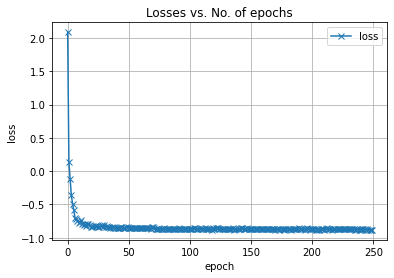

Epoch [init]
GDLoss	CELoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
-0.032	1.8666	1.8338	0.0466	179.96	0.0225	165.48	0.0118	189.41	
Epoch [1]
GDLoss	CELoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
-0.047	0.7522	0.7051	0.0890	146.82	0.0073	153.14	0.0753	172.94	
Epoch [2]
GDLoss	CELoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
-0.074	0.3010	0.2262	0.0318	125.42	0.0000	inf	0.0013	122.42	
Epoch [3]
GDLoss	CELoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
-0.071	0.2894	0.2184	0.0002	inf	0.0000	inf	0.0000	inf	
Epoch [4]
GDLoss	CELoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
-0.075	0.3250	0.2498	0.0012	inf	0.0000	inf	0.0000	inf	
Epoch [5]
GDLoss	CELoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
-0.102	0.2908	0.1879	0.0282	inf	0.0000	inf	0.0000	inf	
Epoch [6]
GDLoss	CELoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
-0.103	0.2629	0.1594	0.0015	inf	0.0000	inf	0.0000	inf	
Epoch [7]
GDLoss	CELoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
-0.128	0.2349	0.1061	0.0122	inf	0.00

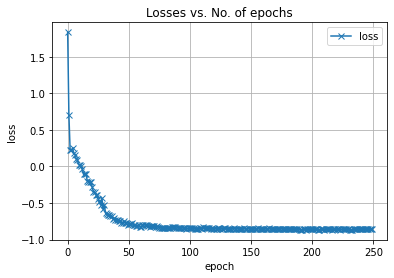

In [ ]:
validators = {
    "SA": Validator(5),
    "LA": Validator(5)
}

for axis in ["SA", "LA"]:
    supervised_training(
        model[axis],
        range(start, EPOCHS),
        torch.utils.data.DataLoader(
            ACDCAllPatients(
                os.path.join("preprocessed/training/labelled/", axis),
                transform=transform_augmentation_downsample
            ),
            batch_size=BATCH_SIZE, shuffle=False, num_workers=0
        ),
        ACDCDataLoader(
            os.path.join("preprocessed/validation/", axis),
            batch_size=BATCH_SIZE, transform=transform
        ),
        validators[axis],
        Checkpointer(os.path.join(CKPT, "M", axis))
    )

    plot_history(validators[axis].get_history("val"))

## $\mathcal{M}$ - Testing

In [ ]:
import torch.nn as nn
import os
import torch
import pickle
import numpy as np

from baseline_1 import Baseline_1
from baseline_2 import Baseline_2
from utils import device
from utils import ACDCDataLoader
from utils import BATCH_SIZE, CKPT
from utils import transform
from utils import infer_predictions
from utils import get_splits
from utils import postprocess_predictions, display_results

In [ ]:
Model = Baseline_2

model = nn.ModuleDict([
    [axis, Model()] for axis in ["SA", "LA"]
]).to(device)

for axis in ["SA", "LA"]:
    ckpt = os.path.join(CKPT, "M", axis, "best_000.pth")
    model[axis].load_state_dict(torch.load(ckpt)["M"])
    model[axis].to(device)
    model.eval()

    infer_predictions(
        os.path.join("inference", axis),
        ACDCDataLoader(
            f"preprocessed/testing/{axis}",
            batch_size = BATCH_SIZE,
            transform = transform,
            transform_gt = False
        ),
        model[axis]
    )

In [ ]:
splits = get_splits(os.path.join(CKPT, "splits.pkl"))

with open(os.path.join("preprocessed", "patient_info.pkl"),'rb') as f:
    patient_info = pickle.load(f)

spacings = [
    patient_info["{:03d}_{}".format(id, axis)]["spacing"] for axis in ["SA", "LA"] for id in (
        splits["train"]["lab"] + splits["train"]["ulab"] + splits["val"]
    )
]

current_spacing = np.percentile(np.vstack(spacings), 50, 0)

In [ ]:
results = {}
for axis in ["SA", "LA"]:
    results[axis] = postprocess_predictions(
        os.path.join("inference", axis),
        patient_info,
        current_spacing,
        os.path.join("postprocessed", axis),
    )

with open("postprocessed/results.pkl", "wb") as f:
    pickle.dump(results,f)

display_results(results)

,RV_ED_DC,RV_ED_HD,RV_ES_DC,RV_ES_HD,RV_DC,RV_HD
axis,,,,,,
SA,0.942414,4.165104,0.890705,5.053776,0.916559,4.609440
LA,0.960029,4.146624,0.940926,3.776361,0.950477,3.961493


## $\mathcal{R}$ - Training

In [ ]:
import torch.nn as nn
import torch
import os

from reconstructor import Reconstructor
from utils import AttrDict
from utils import device
from utils import plot_history
from utils import ACDCAllPatients, ACDCDataLoader
from utils import transform
from utils import BATCH_SIZE, CKPT

In [ ]:
ae = nn.ModuleDict([
    [axis, Reconstructor(
        AttrDict(**{
            "latent_size": 100,
            "lr": 2e-4,
            "last_layer": [4,2,1],
            "in_channels": 4,
            "weighted_epochs": 0
        })
    )] for axis in ["SA", "LA"]
]).to(device)

ckpts = None
if ckpts is not None:
    for axis, ckpt in ckpts.items():
        _, start = os.path.split(ckpt)
        start = int(start.replace(".pth", ""))
        ckpt = torch.load(ckpt)
        ae[axis].load_state_dict(ckpt["R"])
        ae[axis].optimizer.load_state_dict(ckpt["R_optim"])
else:
    start = 0
print(ae)

ModuleDict(
  (SA): Reconstructor(
    (encoder): Sequential(
      (0): Conv2d(4, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
      (3): Dropout(p=0.5, inplace=False)
      (4): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): LeakyReLU(negative_slope=0.2)
      (7): Dropout(p=0.5, inplace=False)
      (8): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): LeakyReLU(negative_slope=0.2)
      (11): Dropout(p=0.5, inplace=False)
      (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (14): Leaky

Epoch [0]
MSELos	GDLoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
0.0249	-0.014	0.0104	0.0000	inf	0.0000	inf	0.0000	inf	
Epoch [1]
MSELos	GDLoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
0.0141	-0.010	0.0038	0.0000	inf	0.0000	inf	0.0000	inf	
Epoch [2]
MSELos	GDLoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
0.0081	-0.193	-0.185	0.4764	25.527	0.1975	15.622	0.4921	23.477	
Epoch [3]
MSELos	GDLoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
0.0074	-0.319	-0.312	0.6634	17.280	0.0411	24.242	0.5193	21.833	
Epoch [4]
MSELos	GDLoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
0.0073	-0.348	-0.340	0.6554	18.316	0.0975	20.760	0.6153	19.271	
Epoch [5]
MSELos	GDLoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
0.0073	-0.378	-0.371	0.6883	15.089	0.1902	16.893	0.5931	19.581	
Epoch [6]
MSELos	GDLoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
0.0071	-0.400	-0.393	0.6929	14.261	0.2428	12.058	0.6014	18.440	
Epoch [7]
MSELos	GDLoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
0.0072	-0.420	-0.4

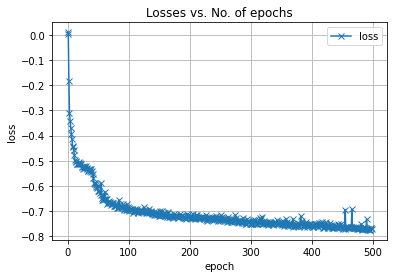

Epoch [0]
MSELos	GDLoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
0.1900	-0.041	0.1490	0.0519	179.77	0.0299	175.80	0.0227	190.67	
Epoch [1]
MSELos	GDLoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
0.1674	-0.040	0.1270	0.0162	179.05	0.0290	175.86	0.0000	170.66	
Epoch [2]
MSELos	GDLoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
0.1453	-0.039	0.1056	0.0000	176.68	0.0239	175.25	0.0000	inf	
Epoch [3]
MSELos	GDLoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
0.1218	-0.038	0.0830	0.0000	inf	0.0000	175.25	0.0000	inf	
Epoch [4]
MSELos	GDLoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
0.0988	-0.037	0.0612	0.0000	inf	0.0000	171.23	0.0000	inf	
Epoch [5]
MSELos	GDLoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
0.0831	-0.036	0.0466	0.0000	inf	0.0000	197.23	0.0000	inf	
Epoch [6]
MSELos	GDLoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
0.0674	-0.034	0.0326	0.0000	inf	0.0000	197.23	0.0000	inf	
Epoch [7]
MSELos	GDLoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
0.0577	-0.033	0.0242	0.0000

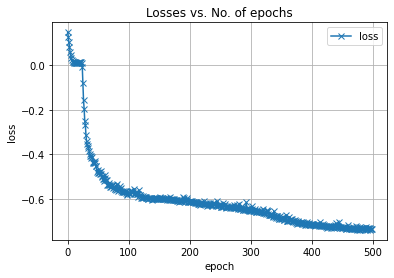

In [ ]:
for axis in ["SA", "LA"]:
    plot_history(ae[axis].training_routine(
        range(start, 500),
        torch.utils.data.DataLoader(
            ACDCAllPatients(
                os.path.join("preprocessed/training/labelled/", axis),
                transform=transform
            ),
            batch_size=BATCH_SIZE, shuffle=False, num_workers=0
        ),
        ACDCDataLoader(
            os.path.join("preprocessed/validation/", axis),
            batch_size=BATCH_SIZE, transform=transform
        ),
        os.path.join(CKPT, "R", axis)
    ))

## QC-based Candidate Selection

In [ ]:
import torch.nn as nn
import os
import torch
import pickle
import numpy as np

from baseline_1 import Baseline_1
from baseline_2 import Baseline_2
from reconstructor import Reconstructor
from utils import device
from utils import AttrDict
from utils import Validator
from utils import ACDCDataLoader
from utils import BATCH_SIZE, CKPT
from utils import transform
from utils import GDLoss, CELoss, GDLoss_RV, CELoss_RV
from utils import infer_predictions
from utils import get_splits
from utils import postprocess_predictions
from utils import display_results

In [ ]:
Model = Baseline_2

model = nn.ModuleDict([
    [axis, Model(
        AttrDict(**{
            "lr": 0.01,
            "functions": [GDLoss, CELoss],
            "functions_RV": [GDLoss_RV, CELoss_RV]
        })
    )] for axis in ["SA", "LA"]
]).to(device)

ae = nn.ModuleDict([
    [axis, Reconstructor(
        AttrDict(**{
            "latent_size": 100,
            "lr": 2e-4,
            "last_layer": [4,2,1],
            "in_channels": 4,
            "weighted_epochs": 0
        })
    )] for axis in ["SA", "LA"]
]).to(device)

validators = {
    "SA": Validator(5),
    "LA": Validator(5)
}

for axis in ["SA", "LA"]:
    ckpt = os.path.join(CKPT, "R", axis)
    ckpt = os.path.join(ckpt, sorted([file for file in os.listdir(ckpt) if "_best" in file])[-1])
    ckpt = torch.load(ckpt)
    ae[axis].load_state_dict(ckpt["R"])
    ae.eval()
    
    for file in os.listdir(os.path.join(CKPT, "M", axis)):
        if "best_" not in file or not file.endswith(".pth"):
            continue
        ckpt = torch.load(os.path.join(CKPT, "M", axis, file))
        model[axis].load_state_dict(ckpt["M"])
        model.eval()
        with torch.no_grad():
            validators[axis].domain_evaluation(
                "test",
                model[axis],
                ACDCDataLoader(
                    f"preprocessed/testing/{axis}",
                    batch_size = BATCH_SIZE,
                    transform = transform,
                    transform_gt = False
                ),    
                reconstructor=ae[axis]
            )


In [ ]:
for axis in ["SA", "LA"]:
    infer_predictions(
        os.path.join("inference", axis),
        ACDCDataLoader(
            f"preprocessed/testing/{axis}",
            batch_size = BATCH_SIZE,
            transform = transform,
            transform_gt = False
        ),
        validator=validators[axis]
    )

In [ ]:
splits = get_splits(os.path.join(CKPT, "splits.pkl"))

with open(os.path.join("preprocessed", "patient_info.pkl"),'rb') as f:
    patient_info = pickle.load(f)

spacings = [
    patient_info["{:03d}_{}".format(id, axis)]["spacing"] for axis in ["SA", "LA"] for id in (
        splits["train"]["lab"] + splits["train"]["ulab"] + splits["val"]
    )
]

current_spacing = np.percentile(np.vstack(spacings), 50, 0)

In [ ]:
results = {}
for axis in ["SA", "LA"]:
    results[axis] = postprocess_predictions(
        os.path.join("inference", axis),
        patient_info,
        current_spacing,
        os.path.join("postprocessed", axis),
    )

with open("postprocessed/results.pkl", "wb") as f:
    pickle.dump(results,f)

display_results(results)

,RV_ED_DC,RV_ED_HD,RV_ES_DC,RV_ES_HD,RV_DC,RV_HD
axis,,,,,,
SA,0.940861,4.395167,0.900695,4.741972,0.920778,4.568570
LA,0.958603,4.091012,0.941138,3.656866,0.949870,3.873939


## Semi-Supervised Refinement

In [ ]:
import torch.nn as nn
import os
import torch
import pickle

from baseline_1 import Baseline_1
from baseline_2 import Baseline_2
from reconstructor import Reconstructor
from utils import AttrDict
from utils import GDLoss, CELoss, GDLoss_RV, CELoss_RV
from utils import device
from utils import Validator, Checkpointer
from utils import semisupervised_refinement
from utils import ACDCDataLoader, ACDCAllPatients
from utils import BATCH_SIZE, EPOCHS, CKPT
from utils import transform_augmentation_downsample, transform
from utils import plot_history

In [ ]:
Model = Baseline_2

model = nn.ModuleDict([
    [axis, Model(
        AttrDict(**{
            "lr": 0.01,
            "functions": [GDLoss, CELoss],
            "functions_RV": [GDLoss_RV, CELoss_RV]
        })
    )] for axis in ["SA", "LA"]
]).to(device)

ae = nn.ModuleDict([
    [axis, Reconstructor(
        AttrDict(**{
            "latent_size": 100,
            "lr": 2e-4,
            "last_layer": [4,2,1],
            "in_channels": 4,
            "weighted_epochs": 0
        })
    )] for axis in ["SA", "LA"]
]).to(device)

validators = {
    "SA": Validator(5),
    "LA": Validator(5)
}

for axis in ["SA", "LA"]:
    ckpt = os.path.join(CKPT, "R", axis)
    ckpt = os.path.join(ckpt, sorted([file for file in os.listdir(ckpt) if "_best" in file])[-1])
    ckpt = torch.load(ckpt)
    ae[axis].load_state_dict(ckpt["R"])
    ae.eval()

    ckpt = os.path.join(CKPT, "M", axis, "200.pth")
    _, start = os.path.split(ckpt)
    start = int(start.replace(".pth", ""))
    ckpt = torch.load(ckpt)
    model[axis].load_state_dict(ckpt["M"])
    model[axis].optimizer.load_state_dict(ckpt["M_optim"])

    ckpt = os.path.join(CKPT, "M", axis, "200_val.pkl")
    with open(ckpt, "rb") as f:
        validators[axis] = pickle.load(f)

print(model)

ModuleDict(
  (SA): Baseline_2(
    (unet): Generic_UNet(
      (conv_blocks_localization): ModuleList(
        (0): Sequential(
          (0): StackedConvLayers(
            (blocks): Sequential(
              (0): ConvDropoutNormNonlin(
                (conv): Conv2d(960, 480, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (instnorm): BatchNorm2d(480, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
              )
            )
          )
          (1): StackedConvLayers(
            (blocks): Sequential(
              (0): ConvDropoutNormNonlin(
                (conv): Conv2d(480, 480, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (instnorm): BatchNorm2d(480, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
              )
            )
          )
        )
        (1): Se

Epoch [init]
GDLoss	CELoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
-0.894	0.0216	-0.872	0.9276	4.2491	0.8610	6.3533	0.9074	7.5368	
Epoch [200 - supervised training]
GDLoss	CELoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	#anom	
-0.892	0.0222	-0.870	0.9282	4.2260	0.8581	8.8614	0.9034	7.6421	9.0000	
Epoch [200 - semisupervised refinement]
GDLoss	CELoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	#anom	
-0.883	0.0243	-0.859	0.9224	6.9435	0.8458	12.528	0.8937	7.9244	5.0000	
Epoch [201 - supervised training]
GDLoss	CELoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	#anom	
-0.886	0.0240	-0.862	0.9326	4.3222	0.8580	6.9690	0.8824	8.3290	4.0000	
Epoch [201 - semisupervised refinement]
GDLoss	CELoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	#anom	
-0.882	0.0251	-0.856	0.9287	4.6784	0.8558	7.8043	0.8738	8.4673	5.0000	
Epoch [202 - supervised training]
GDLoss	CELoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	#anom	
-0.883	0.0270	-0.856	0.9278	4.6528	0.8493	7.0729	0.8864	8.1371	4.0000	
Ep

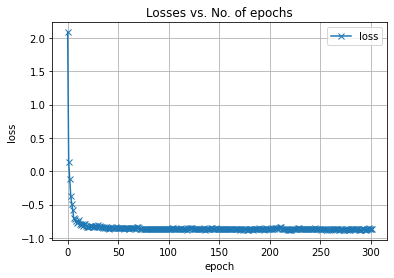

Epoch [init]
GDLoss	CELoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
-0.896	0.0348	-0.861	0.9473	4.1707	0.8451	5.4453	0.9149	6.0329	
Epoch [200 - supervised training]
GDLoss	CELoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	#anom	
-0.895	0.0354	-0.859	0.9467	4.1944	0.8466	5.3587	0.9118	6.5781	8.0000	
Epoch [200 - semisupervised refinement]
GDLoss	CELoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	#anom	
-0.890	0.0375	-0.852	0.9448	6.7810	0.8398	14.434	0.9033	6.5465	10.000	
Epoch [201 - supervised training]
GDLoss	CELoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	#anom	
-0.884	0.0459	-0.838	0.9363	10.534	0.8438	13.252	0.8897	8.1982	7.0000	
Epoch [201 - semisupervised refinement]
GDLoss	CELoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	#anom	
-0.851	0.0701	-0.781	0.9211	11.580	0.8181	13.194	0.8293	17.434	7.0000	
Epoch [202 - supervised training]
GDLoss	CELoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	#anom	
-0.872	0.0482	-0.824	0.9383	9.0688	0.8245	12.192	0.8730	11.956	10.000	
Ep

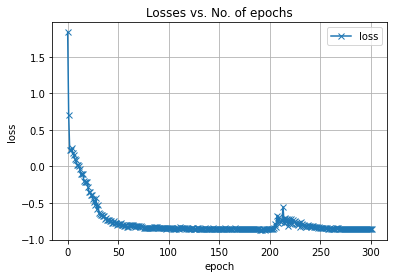

In [ ]:
for axis in ["SA", "LA"]:
    semisupervised_refinement(
        model[axis],
        ae[axis],
        range(start, EPOCHS),
        torch.utils.data.DataLoader(
            ACDCAllPatients(
                os.path.join("preprocessed/training/labelled/", axis),
                transform=transform_augmentation_downsample
            ),
            batch_size=BATCH_SIZE, shuffle=False, num_workers=0
        ),
        ACDCDataLoader(
            os.path.join("preprocessed/validation/", axis),
            batch_size=BATCH_SIZE, transform=transform
        ),
        ACDCDataLoader(
            os.path.join("preprocessed/training/unlabelled/", axis),
            batch_size = BATCH_SIZE, transform=transform
        ),
        validators[axis],
        Checkpointer(os.path.join(CKPT, "M_refinement", axis))
    )

    plot_history(validators[axis].get_history("val"))